In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabpfn import TabPFNRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder
import xgboost as xg 
import torch, gc
import warnings
warnings.simplefilter('ignore', FutureWarning)


torch.cuda.empty_cache()

test_sizes = [0.05*(i+1) for i in range(16)]
output = pd.DataFrame(index=test_sizes, columns = ['XGBoost', 'Random Forest', 'TabPFN'])
data = pd.read_csv('no_duplicates.csv')
# Float to categories
LE = LabelEncoder()
for cat_feature in ['Bug 1', 'Bug 2', 'Carbon']:
    data[cat_feature] = LE.fit_transform(data[cat_feature])

# X and y
to_drop = ['1 on 2: Effect']
y_name = to_drop[0]
y = data[y_name]
X = data.drop(to_drop, axis=1)

In [6]:
output.index = test_sizes
for i in range(15,16):
    gc.collect()
    torch.cuda.empty_cache()

    t = test_sizes[i]
    print(t,1-t)
    # Splitting
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1-t, random_state=42)
    # Fitting
    reg_rf = RandomForestRegressor(random_state=42)
    reg_rf.fit(X_train, y_train)
    reg_tab = TabPFNRegressor(random_state=42,memory_saving_mode=True, device='cuda:1')
    reg_tab.fit(X_train, y_train)
    reg_xgb = xg.XGBRegressor(random_state=42) 
    reg_xgb.fit(X_train, y_train)
    # Testing
    y_pred_rf = reg_rf.predict(X_test)
    r2_rf = round(r2_score(y_pred_rf, y_test),3)
    y_pred_tab = reg_tab.predict(X_test)
    r2_tab = round(r2_score(y_pred_tab, y_test),3)
    y_pred_xgb = reg_xgb.predict(X_test)
    r2_xgb = round(r2_score(y_pred_xgb, y_test),3)
    # Saving
    output.iloc[i, :] = [r2_xgb, r2_rf, r2_tab]
    output.to_csv('output_friedmann.csv')

0.8 0.19999999999999996


Text(0, 0.5, 'R-squared on test set')

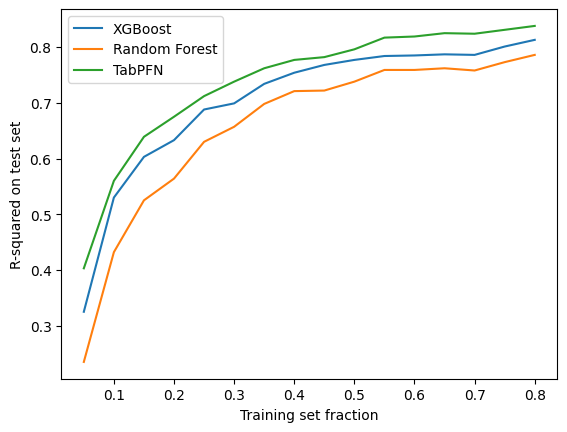

In [26]:
output.plot()
plt.xlabel('Training set fraction')
plt.ylabel('R-squared on test set')